## Link to GDrive


In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 2


## Import libraries and stuff

In [3]:
seed = 69

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [5]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

## Usual import of project material

In [6]:
unzip = False

if unzip:
    !unzip training_dataset.zip

In [7]:
allseries = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
categories = np.load('categories.npy')

## Utility functions

In [ ]:
# Display histogram with categories frequencies
plt.figure(figsize=(17,5))
sns.countplot(x=categories, order=pd.value_counts(categories).index)
plt.title('Categories')
plt.show()

In [ ]:
def group_series_by_category(allseries, categories):
  '''
  Creates a list of series (represented as ndarray) separated based on categories
  '''
  # Builds a df out of the list of series and appends for each one the respective category as last column
  df = pd.DataFrame(allseries)
  df['category'] = categories

  # Takes the created df and gives back all "columns" except the last one
  grouped_series = df.groupby('category').apply(lambda x: x.iloc[:, :-1].to_numpy())

  return grouped_series.to_list()

In [ ]:
def group_periods_by_category(periods, categories):
  '''
  Similarly to the function above, separates validation periods based on categories
  '''
  df = pd.DataFrame(periods)
  df['category'] = categories
  grouped_series = df.groupby('category').apply(lambda x: x.iloc[:, :-1].to_numpy())

  return grouped_series.to_list()

In [ ]:
series_bycat = group_series_by_category(allseries, categories)
periods_bycat = group_periods_by_category(periods, categories)

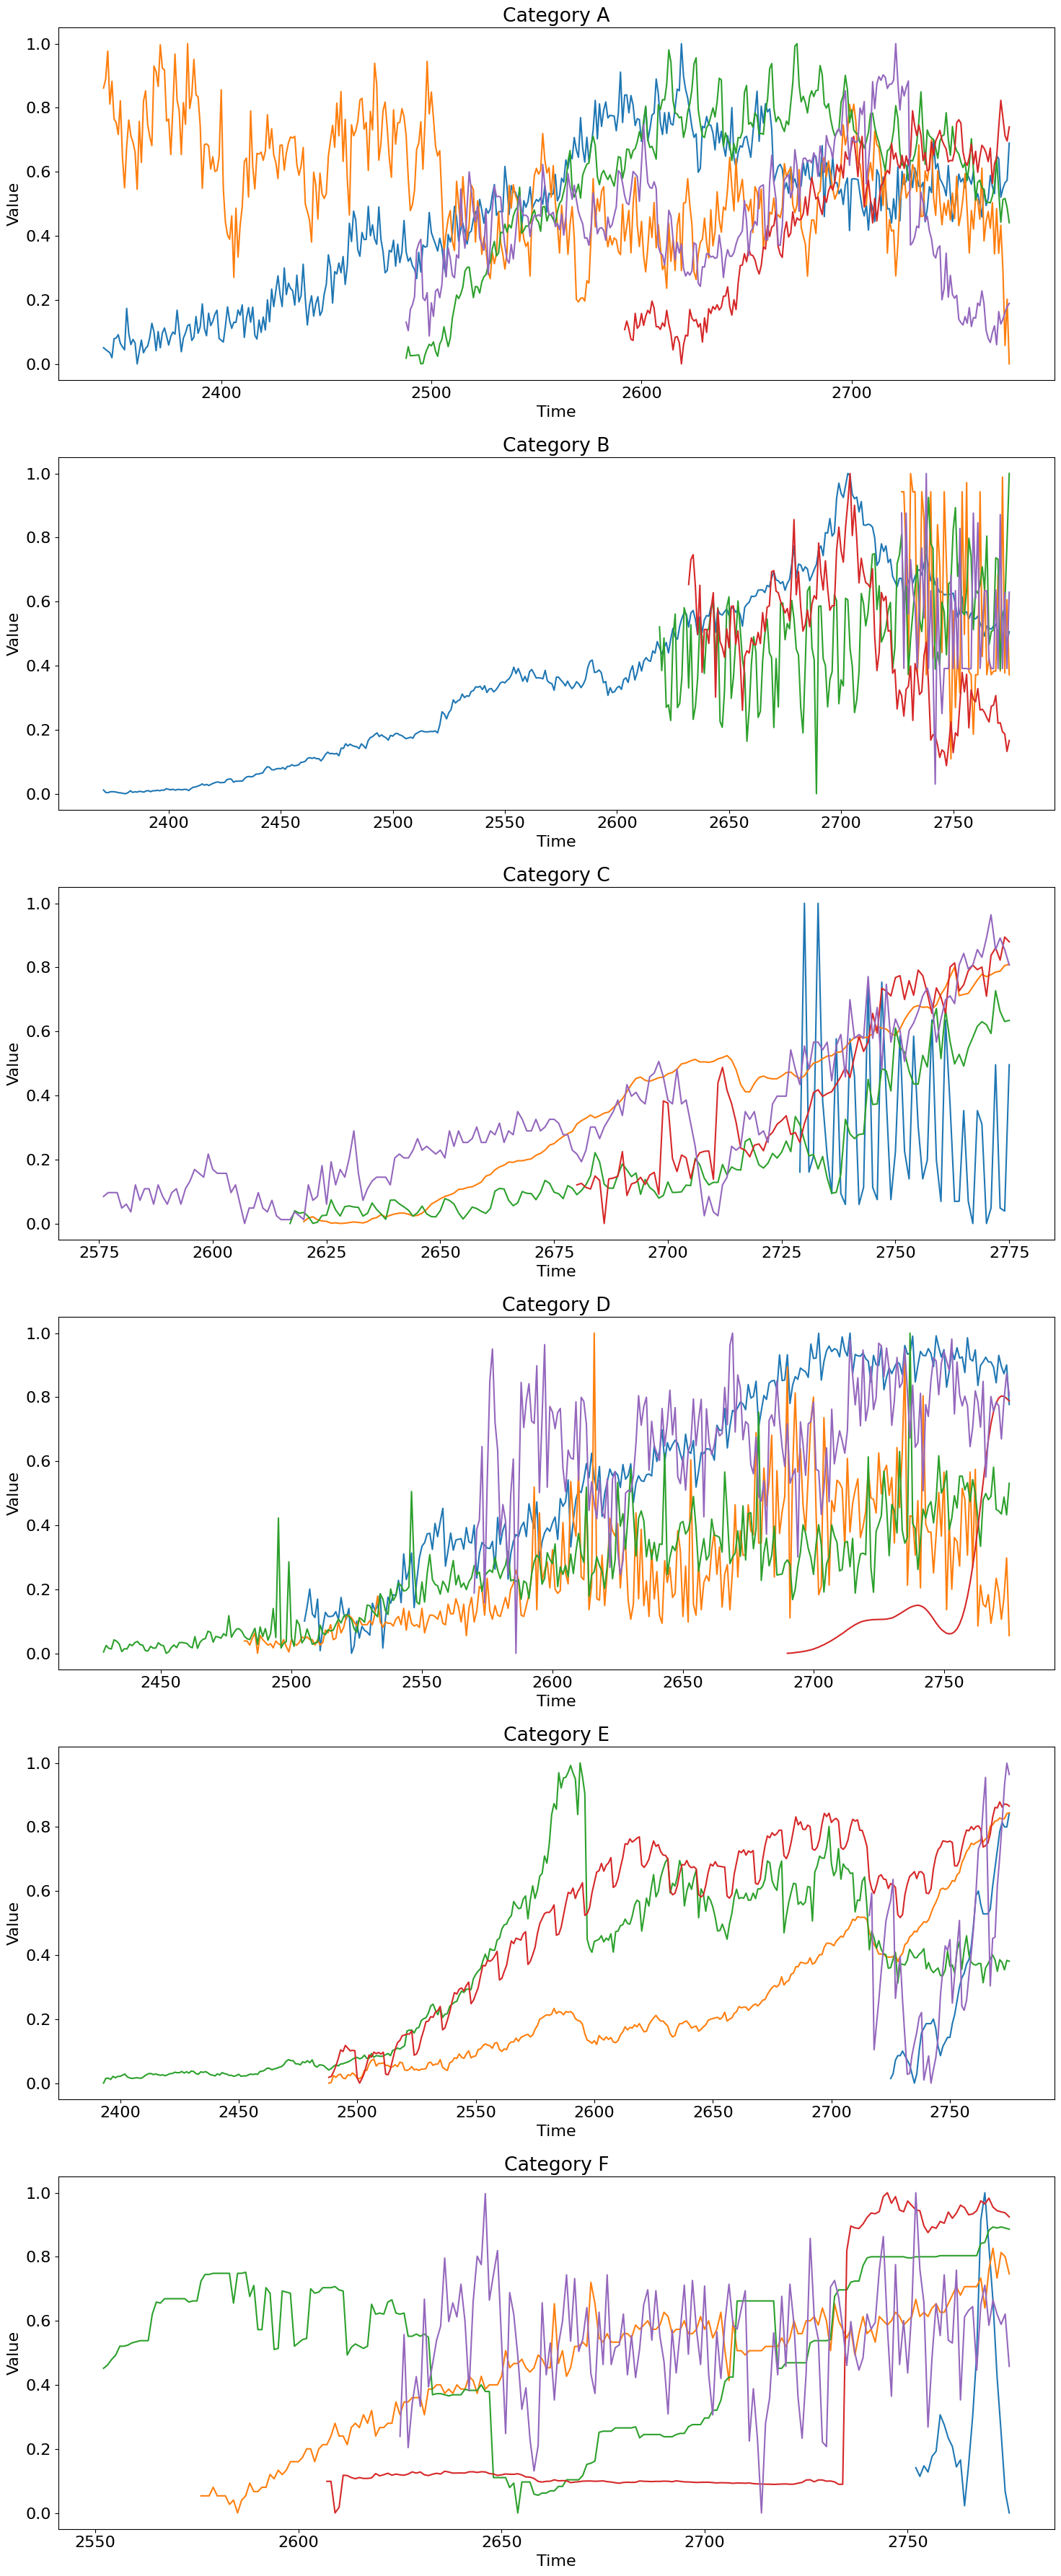

In [ ]:
num_subplots = 6

plt.figure(figsize=(15, 6*num_subplots))

# Block of code just to visualize a fixed number of series for each category
for cindex, cseries in enumerate(series_bycat):
    random_indices = np.random.choice(len(periods_bycat[cindex]), size=5, replace=False)
    plt.subplot(6, 1, cindex + 1)

    for i, index in enumerate(random_indices):
        start, end = periods_bycat[cindex][index]
        selected_series = cseries[index][start:end]
        # Visualize only the valid period for the series, every missing point is padded as 0 in original "dataset"
        plt.plot(np.arange(start, start + len(selected_series)), selected_series)

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Category {np.unique(categories)[cindex]}')

plt.tight_layout()
plt.show()


## Preparation - Classic Approach (later discarded)

In [ ]:
def extract_sequences(data, periods):
  '''
  For each series in input, remove padding up to 50 time instances before
  '''
  sequences = [data[i, np.max([0, start-50]):end] for i, (start, end) in enumerate(periods)]
  return np.array(sequences)

trueseries = extract_sequences(allseries, periods)

In [ ]:
window = 200 # Length of input sequences
stride = {1: 5, 2: 10, 3:1} # Level the number of sequences generated by each category's series, A; B-C-D-E; F
telescope = {1: 9, 2: 18} # Direct prediction for phase 1 and phase 2

In [ ]:
def build_sequences(series, window=200, stride=5, telescope=1):
  '''
  Function taken from lab sessions, build sequences and labels for training from the time series in input
  '''
  assert window % stride == 0
  trainseq = []
  predseq = []

  for serie in series:
    padding_check = len(serie)%window

    # Need to pad the series
    if(padding_check != 0):
        padding_len = window - len(serie)%window
        padding = np.zeros((padding_len), dtype='float32')
        temp_serie = np.concatenate((padding, serie))
        assert len(temp_serie) % window == 0

    # Build actually sequence + label
    for idx in np.arange(0, len(serie) - window - telescope, stride):
        window_seq = temp_serie[idx:idx + window]
        pred_seq = temp_serie[idx + window:idx + window + telescope]

        # If dimension are correct, append the generated sequence + label into the main variables
        if (len(window_seq) == window and len(pred_seq) == telescope):
          trainseq.append(window_seq)
          predseq.append(pred_seq)

    trainseq = np.array(trainseq)
    predseq = np.array(predseq)
    return trainseq, predseq

In [ ]:
# Placeholders for concatenation
X_train = np.empty((0, 200))
Y_train = np.empty((0, 9))

# Generating X_train and Y_train for each category, then merging all
for i in range(6):
  j = 2
  if i < 1: j = 1
  if i > 4: j = 3
  serieTemp = extract_sequences(series_bycat[i], periods_bycat[i])
  X_trainTemp, Y_trainTemp = build_sequences(serieTemp, window, stride[j], telescope[1])
  X_train = np.concatenate((X_train, X_trainTemp), axis=0)
  Y_train = np.concatenate((Y_train, Y_trainTemp), axis=0)
print(X_train.shape, Y_train.shape)

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
input_shape = X_train.shape[1:]
print(input_shape)
output_shape = Y_train.shape[1:]
print(output_shape)
batch_size = 64
epochs = 200

(200, 1)
(9,)


## Preparation - New Approach

In [ ]:
# Building new categories, based on series' length
newcategories = np.empty((48000,), dtype='<U3')
i = -1

for period in periods:
  diff = period[1] - period[0] # Valid period
  i += 1
  if diff < 101:
    newcategories[i] = 'AXS' # Name just to preserve alphabetical order
  elif 100 < diff < 201:
    newcategories[i] = 'BS'
  elif 200 < diff < 501:
    newcategories[i] = 'CM'
  elif 500 < diff < 1001:
    newcategories[i] = 'DL'
  elif 1000 < diff:
    newcategories[i] = 'EXL'

In [ ]:
series_bycat = group_series_by_category(allseries, newcategories)
periods_bycat = group_periods_by_category(periods, newcategories)

In [ ]:
def extract_sequences(data, periods):
  # Same as before but having more padding left, to generate more than 1 sequence from very short series
  sequences = [data[i, np.max([0, start-175]):end] for i, (start, end) in enumerate(periods)]
  return np.array(sequences)

trueseries = extract_sequences(allseries, periods)

In [ ]:
window = 200
stride = {1:5, 2:10, 3:20, 4:25, 5:40} # Avoid creating too much sequences
telescope = {1: 9, 2: 18}
# For autoregression
artelescope = 1

In [ ]:
def build_sequences(series, window=200, stride=10, telescope=100):
  '''
  No changes, check the description on previous block
  '''
  assert window % stride == 0
  trainseq = []
  predseq = []

  for serie in series:
    padding_check = len(serie)%window

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - len(serie)%window
        padding = np.zeros((padding_len), dtype='float32')
        temp_serie = np.concatenate((padding, serie))
        assert len(temp_serie) % window == 0

    for idx in np.arange(0, len(serie) - window - telescope, stride):
        window_seq = temp_serie[idx:idx + window]
        pred_seq = temp_serie[idx + window:idx + window + telescope]

        if (len(window_seq) == window and len(pred_seq) == telescope):
          trainseq.append(window_seq)
          predseq.append(pred_seq)

    trainseq = np.array(trainseq)
    predseq = np.array(predseq)
    return trainseq, predseq

In [ ]:
# This part is basically the same as the one before, but changing telescope when needed

X_train = np.empty((0, 200))
Y_train = np.empty((0, 18))

for i in range(5):
  serieTemp = extract_sequences(series_bycat[i], periods_bycat[i])
  X_trainTemp, Y_trainTemp = build_sequences(serieTemp, window, stride[i+1], telescope[2])
  print(X_trainTemp.shape, Y_trainTemp.shape, stride[i+1])
  X_train = np.concatenate((X_train, X_trainTemp), axis=0)
  Y_train = np.concatenate((Y_train, Y_trainTemp), axis=0)
print(X_train.shape, Y_train.shape)

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)

input_shape = X_train.shape[1:]
print(input_shape)
output_shape = Y_train.shape[1:]
print(output_shape)
batch_size = 64
epochs = 200

(200, 1)
(18,)


## Model N°1 in both phases

In [ ]:
def build(input_shape, telescope):
    output_size = telescope[1] #Change if needed
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(64, return_sequences=True)(lstm)
    lstm = tfkl.LSTM(128)(lstm)
    output_layer = tfkl.Dense(output_size, activation='relu')(lstm)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 1)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 200, 32)           4352      
                                                                 
 lstm_7 (LSTM)               (None, 200, 64)           24832     
                                                                 
 lstm_8 (LSTM)               (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 129161 (504.54 KB)
Trainable params: 129161 (504.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


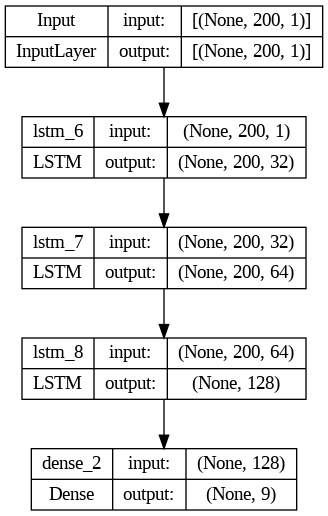

In [ ]:
model = build(input_shape, telescope)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
# This goes for everyone: batch_size and epochs chosen "empirically" on seconds/epoch to complete the training
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 256,
    epochs = 35,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('TopModel')

## Model N°2, decent in the first phase

In [ ]:
def build(input_shape, telescope):
    output_size = telescope[1] # Change if needed
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
    output_layer = tfkl.Conv1D(output_size, 3, padding='same', name='output_layer')(x)
    output_layer = tfkl.GlobalAveragePooling1D()(output_layer)
    output_layer = tfkl.Dense(output_size, activation='relu')(output_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    return model

In [ ]:
model = build(input_shape, telescope)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 256,
    epochs = 40,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('OkModel')

## Other models we tried, included for completeness sake. During the challenge they were discarded for poor performances wrt previous ones

In [ ]:
from keras.models import Sequential
def build(input_shape, telescope):
    output_size = telescope[1]
    model = Sequential()
    model.add(tfkl.Conv1D(filters=32, kernel_size=2, strides=1, padding="causal", activation="relu", input_shape=input_shape))
    model.add(tfkl.Conv1D(filters=16, kernel_size=2, strides=1, padding="causal", activation="relu", input_shape=input_shape))
    model.add(tfkl.MaxPooling1D(pool_size=2))
    model.add(tfkl.LSTM(128))
    model.add(tfkl.Dense(output_size, activation='linear'))
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    return model

In [ ]:
model = build(input_shape, telescope)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 256,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('2Conv1D+LSTM')

In [ ]:
def build_model(input_shape, telescope):
    output_shape = telescope[1]
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    layer = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True))(input_layer)
    layer = tfkl.Conv1D(64, 3, padding='same', activation='relu')(layer)
    layer = tfkl.MaxPool1D()(layer)
    layer = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True))(layer)
    layer = tfkl.Conv1D(128, 6, padding='same', activation='relu')(layer)
    layer = tfkl.MaxPool1D()(layer)
    layer = tfkl.Bidirectional(tfkl.GRU(256, return_sequences=True))(layer)
    layer = tfkl.Conv1D(256, 12, padding='same', activation='relu')(layer)
    layer = tfkl.GlobalAveragePooling1D()(layer)
    layer = tfkl.Dropout(.25)(layer)
    output_layer = tfkl.Dense(output_shape, activation='relu')(layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
model = build_model(input_shape, telescope)
model.summary()
tfk.utils.plot_model(model)

In [ ]:
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 256,
    epochs = 200,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('GRU')

In [ ]:
# Trying to include Attention layers, but lately not useful
def build(input_shape, telescope):
    output_size = telescope[1]
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(32, return_sequences=True)(input_layer)

    attention = tfkl.Attention()([lstm, lstm])
    lstm = tf.keras.layers.Concatenate(axis=-1)([lstm, attention])

    lstm = tfkl.LSTM(64, return_sequences=True)(lstm)

    attention = tfkl.Attention()([lstm, lstm])
    lstm = tf.keras.layers.Concatenate(axis=-1)([lstm, attention])

    lstm = tfkl.LSTM(128)(lstm)

    attention = tfkl.Attention()([lstm, lstm])
    lstm = tf.keras.layers.Concatenate(axis=-1)([lstm, attention])

    output_layer = tfkl.Dense(output_size, activation='relu')(lstm)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam())

    return model

In [ ]:
model = build(input_shape, telescope)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = 512,
    epochs = 50,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Attention')